In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from pymongo import MongoClient
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from utils import db

In [2]:
display(db.list_database_names())

display(db.list_collection_names('test_db'))

['admin', 'config', 'index_check', 'local', 'test_db']

['USDT-ETH', 'fred', 'USDT-BTC', 'news']

In [3]:
eth_df = db.df_from_db("test_db", "USDT-ETH")
btc_df = db.df_from_db("test_db", "USDT-BTC")
fred_df = db.df_from_db("test_db", "fred")
news_df = db.df_from_db("test_db", "news")


## missing 데이터 확인

In [4]:

def check_missing(df:pd.DataFrame, time_col:str , freq:str):
    """ check if data has missing rows
    Args:
        time_col: 'etz_time', 'utc_time'
        freq: '1H', '1D'
    """
    min_time = df[time_col].min()
    max_time = df[time_col].max()
    date_index = pd.date_range(start=min_time,
                               end=max_time, freq=freq)
    print("데이터 시간 범위", end=': ')
    print(date_index[0], date_index[-1])
    print("데이터 시간 범위", end=': ')
    print(min_time, max_time)
    print(len(date_index), len(df))
    assert len(date_index) == len(df)
    


In [5]:
check_missing(btc_df, 'utc_time', '1H')

데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
22550 22550


In [6]:
check_missing(eth_df, 'utc_time', '1H')

데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
데이터 시간 범위: 2020-01-01 00:00:00 2022-07-28 13:00:00
22550 22550


In [7]:
check_missing(fred_df, 'etz_time', '1D')

데이터 시간 범위: 2019-12-31 23:59:00 2022-07-26 23:59:00
데이터 시간 범위: 2019-12-31 23:59:00 2022-07-26 23:59:00
939 939


In [8]:
check_missing(news_df, 'etz_time', '1D')

데이터 시간 범위: 2019-12-31 23:59:00 2022-07-29 23:59:00
데이터 시간 범위: 2019-12-31 23:59:00 2022-07-29 23:59:00
942 942


## Summer time 적용하지 않은 est 시간 적용

In [9]:
def make_etz_time(df: pd.DataFrame, utc_col:str='utc_time', new_col:str='etz_time', time_diff = -5):
    df[new_col] = df[utc_col] + dt.timedelta(hours=time_diff)
    return df
    
btc_df = make_etz_time(btc_df)
eth_df = make_etz_time(eth_df)




## 서버 점검시간 & 누락 데이터 확인 확인

In [10]:
btc_df = btc_df.sort_values('utc_time')
eth_df = eth_df.sort_values('utc_time')

In [11]:
def check_server_maintenance_time(df):
    df = df[df.candle_date_time_utc != df.utc_time - dt.timedelta(hours=1)]
    return df
    
missing_btc_df = check_server_maintenance_time(btc_df)
missing_eth_df = check_server_maintenance_time(eth_df)

print(f"점검시간 비율: {len(missing_btc_df) / len(btc_df):.4f}")
print(f"점검시간 비율: {len(missing_eth_df) / len(eth_df):.4f}")


점검시간 비율: 0.1202
점검시간 비율: 0.3753


## 일단위 데이터로 groupby
- opening_price	시가	Double
- high_price	고가	Double
- low_price	저가	Double
- trade_price	종가	Double
- candle_acc_trade_price	누적 거래 금액	Double
- candle_acc_trade_volume	누적 거래량	Double

In [12]:
hourly_btc_df = btc_df.copy()

In [13]:

hourly_btc_df['etz_date'] = hourly_btc_df['etz_time'].apply(lambda x: x.date())
conditions = {
            "etz_time": "first",
            "opening_price": "first",
            "high_price": "max", 
            "low_price": "min",  
            "trade_price": "last",
            "candle_acc_trade_price": "sum",
            "candle_acc_trade_volume": "sum"
    }
daily_btc_df = hourly_btc_df.groupby('etz_date').agg(conditions)
daily_btc_df = daily_btc_df.reset_index()
drop_fisrt = True


if daily_btc_df.etz_time.iloc[0].hour != 0 and drop_fisrt:
    daily_btc_df = daily_btc_df.iloc[1:]



In [14]:
daily_btc_df = daily_btc_df.set_index('etz_date')
hourly_btc_df = hourly_btc_df.set_index('etz_time')

daily_btc_df.index = pd.to_datetime(daily_btc_df.index)
hourly_btc_df.index = pd.to_datetime(hourly_btc_df.index)


## 로그차분 그래프 확인

- 1차 차분

In [15]:


def make_log_df(df:pd.DataFrame, col_name:str):
    df[f'log_diff_{col_name}'] = np.log(df[col_name]) - np.log(df[col_name].shift(1))
    # np.log(btc_df['trade_price']).diff()
    return df.dropna()

hourly_btc_df = make_log_df(hourly_btc_df, 'trade_price')
daily_btc_df = make_log_df(daily_btc_df, 'trade_price')



In [16]:
import statsmodels.tsa.api as tsa


In [17]:
titles = """hourly_btc_df.trade_price,
hourly_btc_df.log_diff_trade_price,
daily_btc_df.trade_price,
daily_btc_df.log_diff_trade_price"""
titles = titles.split('\n')

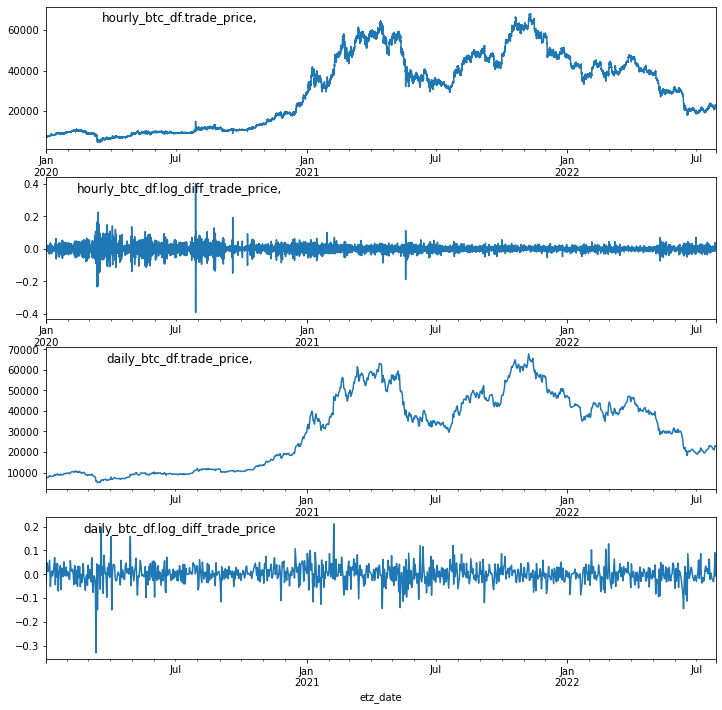

In [18]:

series_list = [hourly_btc_df.trade_price,
           hourly_btc_df.log_diff_trade_price,
           daily_btc_df.trade_price,
           daily_btc_df.log_diff_trade_price]

nrow = 4
ncol = 1

fig = plt.figure(figsize=(12, 12))

count = 0
for r in range(nrow):
    for c in range(ncol):
        ax = fig.add_subplot(nrow, ncol, count+1 )
        series_list[count].plot()
        ax.set_title(x=.2, y=0.85,label=titles[count])
        count+=1
        

## 통계값 확인
- 00 그림
    - 그래프 & MA 그래프
    - Q-Stat: Ljung-Box Q Statistic
        - LBQ 통계량이 지정 임계값보다 크면 하나 이상의 시차에 대한 자기 상관이 0과 유의하게 다르며, 값이 일정 기간 랜덤 및 독립적이 아니라는 것을 의미
    - ADF test: Augmented Dickey–Fuller test, 정상성 검정
        - p-value가 0.05 이상인 경우 데이터에 단위근이 있으며 정상성을 가지지 않다고 판단할 수 있음
- 01 그림
    - 모멘텀
    - probplot: Q-Q plot, normal 분포와 시각화
- 10 그림
    - ACF: 자기 상관함수, 그래프가 비교적 빠르게 0으로 떨어짐 → 정상성 가질 수 있음 
- 11 그림
    - PACF: 편자기 상관함수
    - 자기상관계수는 시점 t에서 t-1, t-2, … 와의 상관계수를 의미한다. 하지만, 시계열의 특성상 t시점과 t-2와의 상관 계수 ($r_{2}$) 에는 t-2 → t-1 → t 로 이어지는 간접적인 상관계수$(r_{1})$이 포함되기 때문에 t시점에서 t-2에 직접적인 상관성만 고려하기 위한 상관계수함



- Reference: 
    - https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/09_time_series_models/01_tsa_and_stationarity.ipynb

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
import seaborn as sns


/home/nys/anaconda3/envs/EDA-exercise/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/nys/anaconda3/envs/EDA-exercise/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/nys/anaconda3/envs/EDA-exercise/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


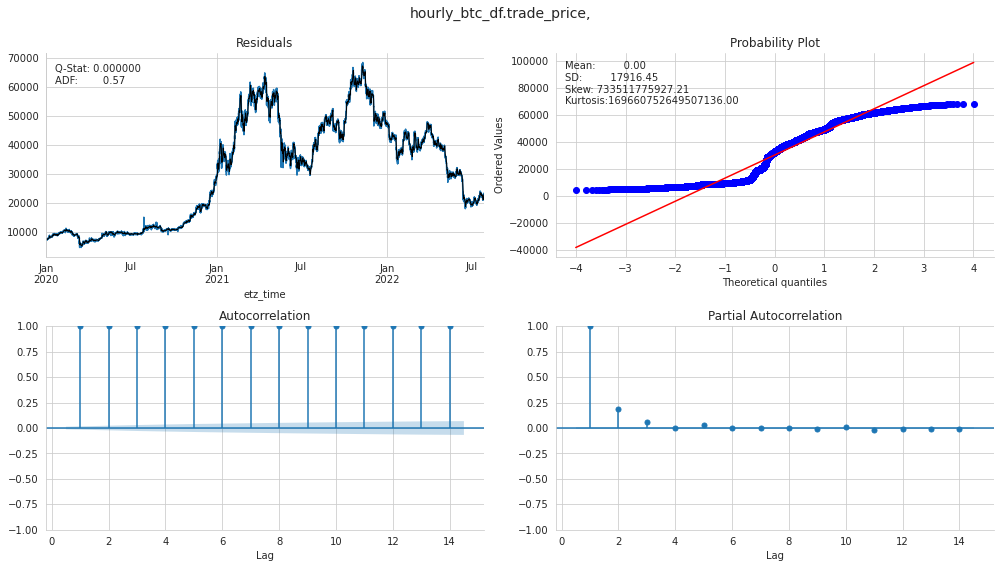

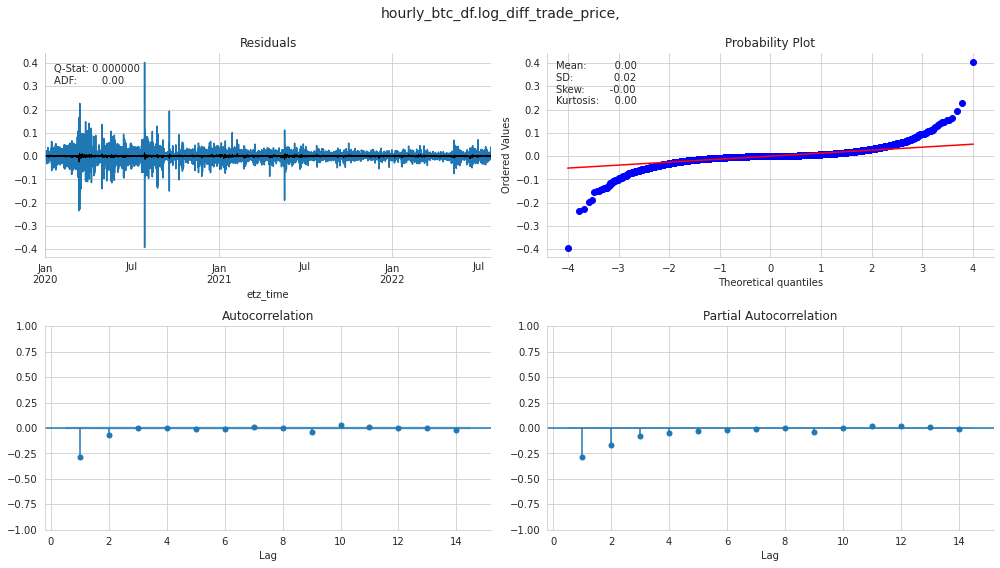

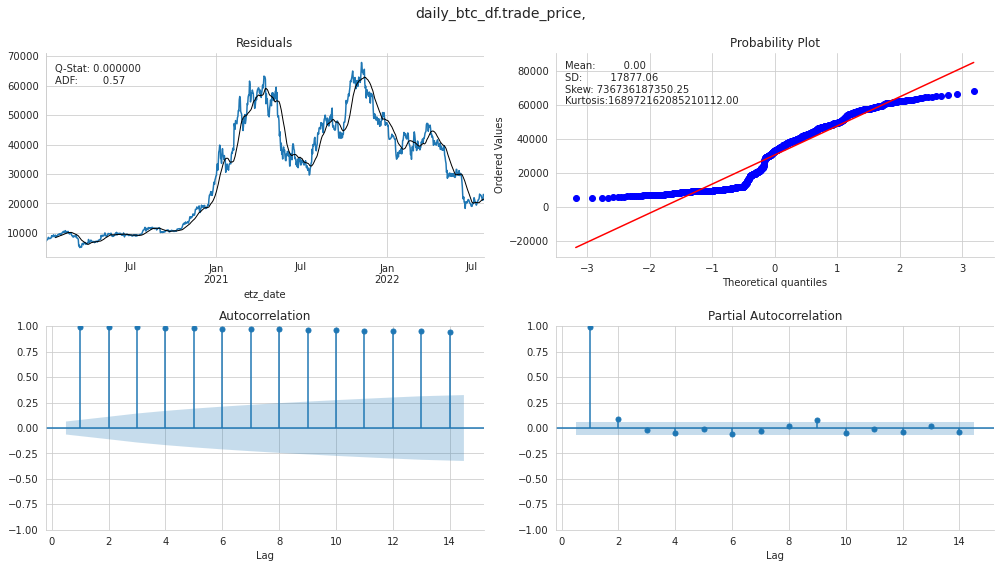

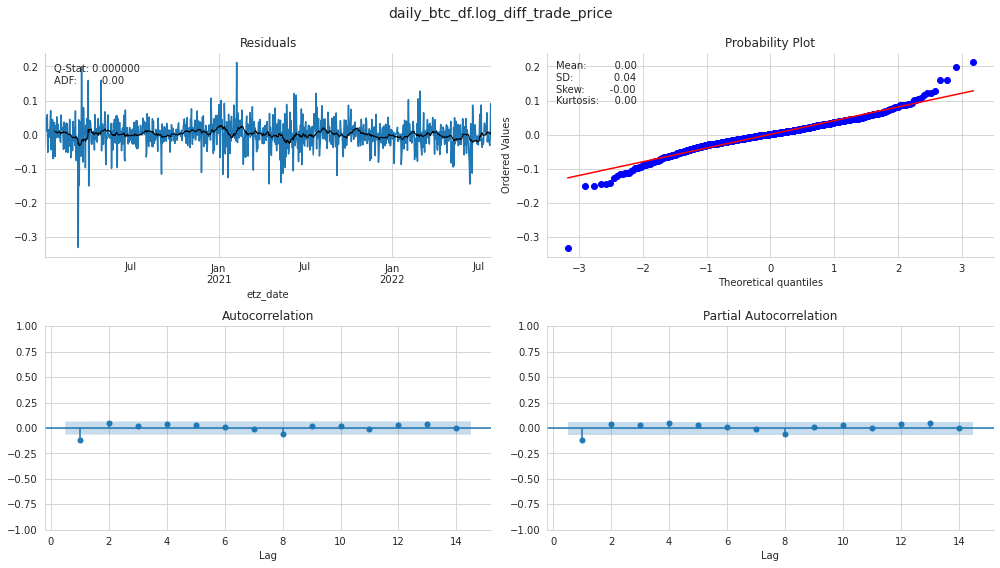

In [20]:
def plot_correlogram(x, lags=None, title=None):
    lags = min(28, int(len(x)/7)) if lags is None else lags
    with sns.axes_style('whitegrid'):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
        x.plot(ax=axes[0][0], title='Residuals')
        x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
        q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
        stats = f'Q-Stat: {np.max(q_p):>8.6f}\nADF: {adfuller(x)[1]:>11.2f}'
        axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
        
        
        probplot(x,dist='norm', plot=axes[0][1])
        mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
        s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
        axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
        
        ## ACF, PACF
        plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
        plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
        axes[1][0].set_xlabel('Lag')
        axes[1][1].set_xlabel('Lag')
        fig.suptitle(title, fontsize=14)
        sns.despine()
        fig.tight_layout()
        fig.subplots_adjust(top=.9)

for i in range(len(series_list)):
    plot_correlogram(series_list[i], lags=14, title=titles[i])

## 정상성 확인

- KPSS 검정: 귀무-정상성을 가짐 / 대립-정상성을 가지지 않음

- ADF 검정: 귀무-정상성을 가지지 않음 / 대립-정상성을 가짐



In [21]:
####################################################################################
# Docstring:
# Kwiatkowski-Phillips-Schmidt-Shin test for stationarity.

# Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for the null
# hypothesis that x is level or trend stationary.

# Parameters
# ----------
# x : array_like, 1d
#     The data series to test.
# regression : str{"c", "ct"}
#     The null hypothesis for the KPSS test.

#     * "c" : The data is stationary around a constant (default).
#     * "ct" : The data is stationary around a trend.
# nlags : {str, int}, optional
#     Indicates the number of lags to be used. If "auto" (default), lags
#     is calculated using the data-dependent method of Hobijn et al. (1998).
#     See also Andrews (1991), Newey & West (1994), and Schwert (1989). If
#     set to "legacy",  uses int(12 * (n / 100)**(1 / 4)) , as outlined in
#     Schwert (1989).
# store : bool
#     If True, then a result instance is returned additionally to
#     the KPSS statistic (default is False).

# Returns
# -------
# kpss_stat : float
#     The KPSS test statistic.
# p_value : float
#     The p-value of the test. The p-value is interpolated from
#     Table 1 in Kwiatkowski et al. (1992), and a boundary point
#     is returned if the test statistic is outside the table of
#     critical values, that is, if the p-value is outside the
#     interval (0.01, 0.1).
# lags : int
#     The truncation lag parameter.
# crit : dict
#     The critical values at 10%, 5%, 2.5% and 1%. Based on
#     Kwiatkowski et al. (1992).
# resstore : (optional) instance of ResultStore
#     An instance of a dummy class with results attached as attributes.

####################################################################################

# Docstring:
# Augmented Dickey-Fuller unit root test.

# The Augmented Dickey-Fuller test can be used to test for a unit root in a
# univariate process in the presence of serial correlation.

# Parameters
# ----------
# x : array_like, 1d
#     The data series to test.
# maxlag : {None, int}
#     Maximum lag which is included in test, default value of
#     12*(nobs/100)^{1/4} is used when ``None``.
# regression : {"c","ct","ctt","n"}
#     Constant and trend order to include in regression.

#     * "c" : constant only (default).
#     * "ct" : constant and trend.
#     * "ctt" : constant, and linear and quadratic trend.
#     * "n" : no constant, no trend.

# autolag : {"AIC", "BIC", "t-stat", None}
#     Method to use when automatically determining the lag length among the
#     values 0, 1, ..., maxlag.

#     * If "AIC" (default) or "BIC", then the number of lags is chosen
#       to minimize the corresponding information criterion.
#     * "t-stat" based choice of maxlag.  Starts with maxlag and drops a
#       lag until the t-statistic on the last lag length is significant
#       using a 5%-sized test.
#     * If None, then the number of included lags is set to maxlag.
# store : bool
#     If True, then a result instance is returned additionally to
#     the adf statistic. Default is False.
# regresults : bool, optional
#     If True, the full regression results are returned. Default is False.

# Returns
# -------
# adf : float
#     The test statistic.
# pvalue : float
#     MacKinnon's approximate p-value based on MacKinnon (1994, 2010).
# usedlag : int
#     The number of lags used.
# nobs : int
#     The number of observations used for the ADF regression and calculation
#     of the critical values.
# critical values : dict
#     Critical values for the test statistic at the 1 %, 5 %, and 10 %
#     levels. Based on MacKinnon (2010).
# icbest : float
#     The maximized information criterion if autolag is not None.
# resstore : ResultStore, optional
#     A dummy class with results attached as attributes.




In [22]:
test_results = []
for i in range(len(series_list)):
    result = {"title":titles[i]}
    kpss_stat, kpass_pval, kpss_lag, kpss_crit= tsa.kpss(series_list[i])
    result.update(kpss_stat=kpss_stat, kpass_pval=kpass_pval, kpss_lag=kpss_lag, kpss_crit=kpss_crit)

    adf_stat, adf_pval, adf_usedlag, adf_obs, adf_cvals, adf_icbest = tsa.adfuller(series_list[i])
    result.update(adf_stat=adf_stat, adf_pval=adf_pval, adf_usedlag=adf_usedlag, 
                  adf_cvals=adf_cvals, adf_obs=adf_obs, adf_icbest=adf_icbest)
    test_results.append(result)
    

/home/nys/anaconda3/envs/EDA-exercise/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/nys/anaconda3/envs/EDA-exercise/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [23]:
test_df = pd.DataFrame(test_results)

### ADF test를 보면 귀무가설을 상당히 지지 안하는 것처럼 보이지만, 그렇다고 KPSS의 귀무가설을 그렇게 지지하지도 않음

In [24]:
test_df

,title,kpss_stat,kpass_pval,kpss_lag,kpss_crit,adf_stat,adf_pval,adf_usedlag,adf_cvals,adf_obs,adf_icbest
0,"hourly_btc_df.trade_price,",13.980880,0.010000,91,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...",-1.424326,0.57056,34,"{'1%': -3.430640487951374, '5%': -2.8616683862...",22514,327147.129337
1,"hourly_btc_df.log_diff_trade_price,",0.454783,0.053542,122,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...",-23.312563,0.00000,42,"{'1%': -3.4306405912202242, '5%': -2.861668431...",22506,-127289.646580
2,"daily_btc_df.trade_price,",2.717546,0.010000,19,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...",-1.425009,0.57023,1,"{'1%': -3.4373481911362997, '5%': -2.864629502...",937,15855.419241
3,daily_btc_df.log_diff_trade_price,0.438549,0.060539,6,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...",-34.412095,0.00000,0,"{'1%': -3.4373407098114765, '5%': -2.864626204...",938,-3244.881147


## 시계열 성분 분해

- 추세, 계절성, 잔차 성분 분해 & 시각화

- Reference: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/09_time_series_models/01_tsa_and_stationarity.ipynb

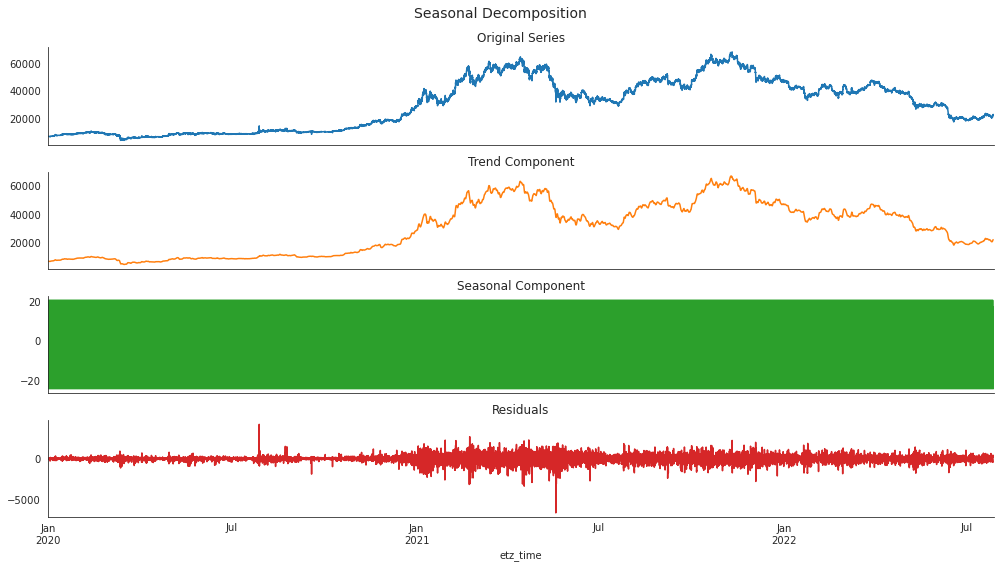

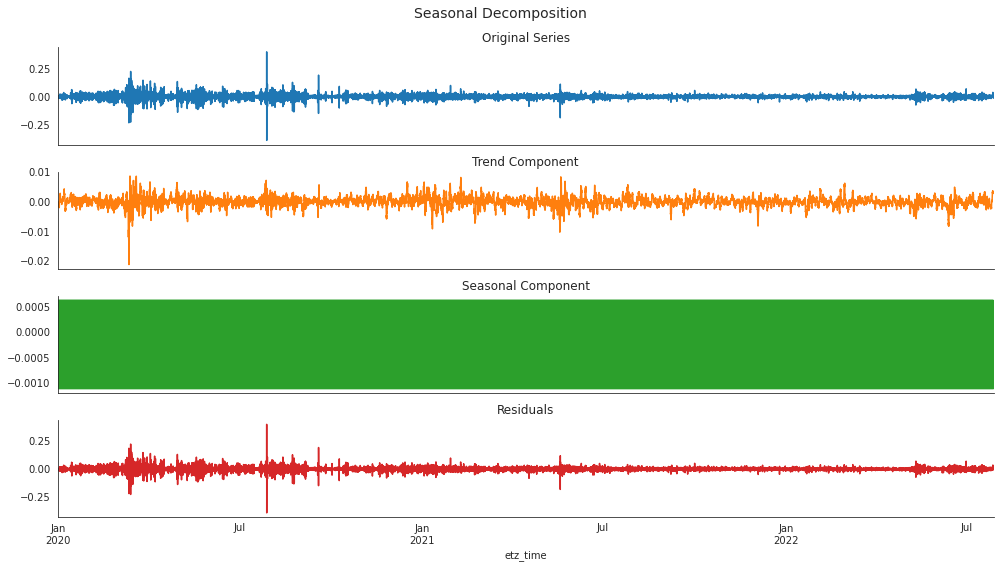

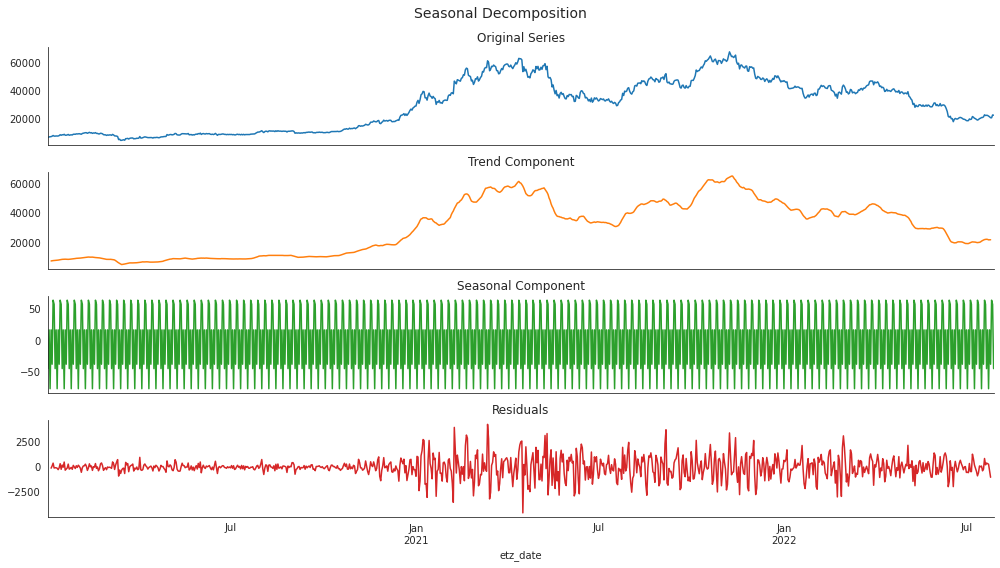

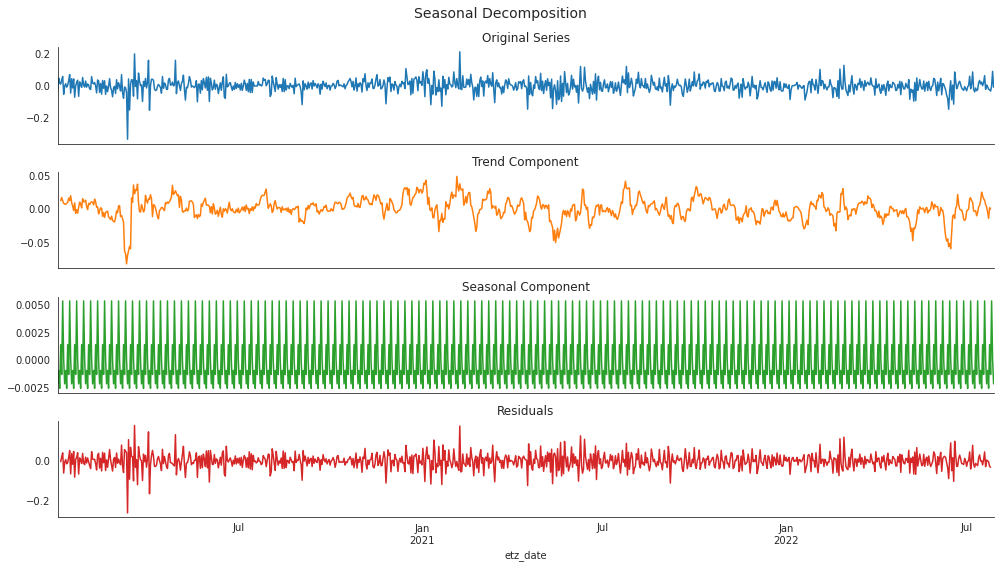

In [25]:
def tsa_decompose(x, suptitle):
    components = tsa.seasonal_decompose(x, model='additive')
    ts = (x.to_frame('Original')
          .assign(Trend=components.trend)
          .assign(Seasonality=components.seasonal)
          .assign(Residual=components.resid))
    with sns.axes_style('white'):
        ts.plot(subplots=True, figsize=(14, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
        plt.suptitle('Seasonal Decomposition', fontsize=14)
        sns.despine()
        plt.tight_layout()
        plt.subplots_adjust(top=.91);

for i in range(len(series_list)):
    tsa_decompose(series_list[i],suptitle=titles[i])
    
    

## Appedix
- Calcuate PACF & ACF using numpy

In [26]:
# modified from 
# https://stackoverflow.com/questions/20110590/how-to-calculate-auto-covariance-in-python
# PACF formula
# https://stats.stackexchange.com/questions/129052/acf-and-pacf-formula

import numpy as np
import re
import statsmodels.tsa.api as tsa
## Data R passengers data diff(AirPassengers)
data = """      
      Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
1949         6   14   -3   -8   14   13    0  -12  -17  -15   14
1950   -3   11   15   -6  -10   24   21    0  -12  -25  -19   26
1951    5    5   28  -15    9    6   21    0  -15  -22  -16   20
1952    5    9   13  -12    2   35   12   12  -33  -18  -19   22
1953    2    0   40   -1   -6   14   21    8  -35  -26  -31   21
1954    3  -16   47   -8    7   30   38   -9  -34  -30  -26   26
1955   13   -9   34    2    1   45   49  -17  -35  -38  -37   41
1956    6   -7   40   -4    5   56   39   -8  -50  -49  -35   35
1957    9  -14   55   -8    7   67   43    2  -63  -57  -42   31
1958    4  -22   44  -14   15   72   56   14 -101  -45  -49   27
1959   23  -18   64  -10   24   52   76   11  -96  -56  -45   43
1960   12  -26   28   42   11   63   87  -16  -98  -47  -71   42"""
data = re.findall(r'-?\d+', data)
data = [int(i) for i in data ]
data = [i for i in data if i < 1000]
Xi = data

N = np.size(Xi)
k = 5
Xs = np.average(Xi)



def autocovariance(Xi, N, k, Xs, adjusted = False):
    autoCov = 0
    for i in np.arange(0, N-k):
        autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
    denom = (N-k) if adjusted else N
    return (1/(denom))*autoCov

def autocorrelation(Xi, N, k, Xs):
    return autocovariance(Xi, N, k, Xs) / autocovariance(Xi, N, 0, Xs)

# 
def make_toeplitz(acf_vals):
    acf_matrix = [acf_vals.copy() for i in range(len(acf_vals))]
    for i in range(0,len(acf_vals)):
        acf_matrix[i][:i+1] = acf_vals[:i+1][::-1]
        acf_matrix[i][i+1:] = acf_vals[1: len(acf_vals)-i]
    return acf_matrix


print("Autocovariance:", autocovariance(Xi, N, k, Xs, adjusted=False))
print("Autocorrelation:", autocorrelation(Xi, N, k, Xs))
print("Sample Autocovariance:", autocovariance(Xi, N, k, Xs, adjusted=True))

acf_vals = tsa.acf(Xi,nlags = k)
# use: scipy.linalg.toeplitz(acf_vals[:k])
acf_matrix = make_toeplitz(acf_vals[:k])
acf_matrix = np.array(acf_matrix)
# using left pseudo inverse
pacf = np.linalg.inv(acf_matrix.T @ acf_matrix) @ acf_matrix.T @ acf_vals[1:k+1]
# use np.linalg.solve for system of equations

print("Partial Autocovariance:", pacf[-1])
print()

import statsmodels.tsa.api as tsa

acvf_at5 = tsa.acovf(Xi, nlag = k)[-1] 
acf_at5 = tsa.acf(Xi,nlags = k)[-1]
print("Autocovariance:", acvf_at5)
# print("sample Autocovariance:", sample_acvf_at5)
print("Autocorrelation:",acf_at5)

print("Sample Autocovariance:", tsa.acovf(Xi, nlag = k, adjusted=True)[-1])
print("Partial Autocovariance:", tsa.pacf(Xi,5, 'ldb')[-1])

Autocovariance: -106.43236439827959
Autocorrelation: -0.09407271245807856
Sample Autocovariance: -110.28860948517378
Partial Autocovariance: 0.010083794316645259

Autocovariance: -106.43236439827956
Autocorrelation: -0.09407271245807855
Sample Autocovariance: -110.28860948517375
Partial Autocovariance: 0.010083794316645335
